In [56]:
# Based on https://hackernoon.com/dont-be-fooled-deceptive-cryptocurrency-price-predictions-using-deep-learning-bf27e4837151
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Activation, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm, tqdm_notebook
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop


endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content.decode('utf-8'))['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-12-10,1033.72,1067.70,911.96,918.95,22103.22,21734994.03
2013-12-11,919.93,1056.76,856.06,1033.72,24360.35,23051224.54
2013-12-12,899.98,940.98,839.51,919.93,9913.21,8798283.62
2013-12-13,936.77,989.89,882.11,899.98,17372.49,16173632.88
2013-12-14,908.94,947.93,875.11,936.77,11589.80,10532106.73


In [57]:
hist.tail()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-05-29,8664.56,8760.48,8444.10,8718.85,44056.71,3.803439e+08
2019-05-30,8276.25,9065.89,8027.21,8664.56,95189.06,8.155256e+08
2019-05-31,8550.67,8570.78,8116.00,8276.25,60143.23,5.020565e+08
2019-06-01,8555.87,8619.21,8459.65,8550.67,26884.15,2.297370e+08
2019-06-02,8703.97,8819.90,8547.48,8555.87,19245.15,1.672216e+08


In [58]:
len(hist)

2001

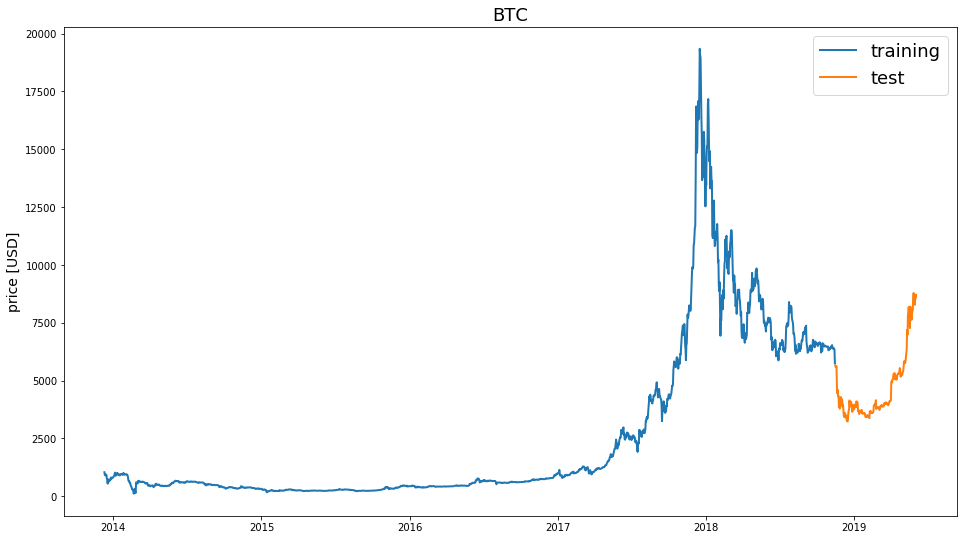

In [59]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
train, test = train_test_split(hist, test_size=0.1)
line_plot(train.close, test.close, 'training', 'test', 'BTC')

In [60]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.close[window:].values
    y_test = test_data.close[window:].values
    if zero_base:
        y_train = y_train / train_data.close[:-window].values - 1
        y_test = y_test / test_data.close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [82]:
print(X_train.shape)
print(X_train.shape)
print(y_test.shape)
print(y_test.shape)

(1794, 7, 6)
(1794, 7, 6)
(193,)
(193,)


In [75]:
def build_lstm_model(input_data, output_size, neurons=20,
                     activ_func='linear', dropout=0.25,
                     loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

model = build_lstm_model(X_train, output_size=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=4)


Epoch 1/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0755
Epoch 2/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0492
Epoch 3/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0425
Epoch 4/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0382
Epoch 5/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0387
Epoch 6/50
1794/1794 [==============================] - 6s 3ms/step - loss: 0.0370
Epoch 7/50
1794/1794 [==============================] - 6s 3ms/step - loss: 0.0353
Epoch 8/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0359
Epoch 9/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0342
Epoch 10/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0335
Epoch 11/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0340
Epoch 12/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0332
E

In [76]:
targets = test.close[7:]
preds = model.predict(X_test).squeeze()

In [77]:
from sklearn import metrics

metrics.mean_absolute_error(preds, y_test)

0.02548403579811455

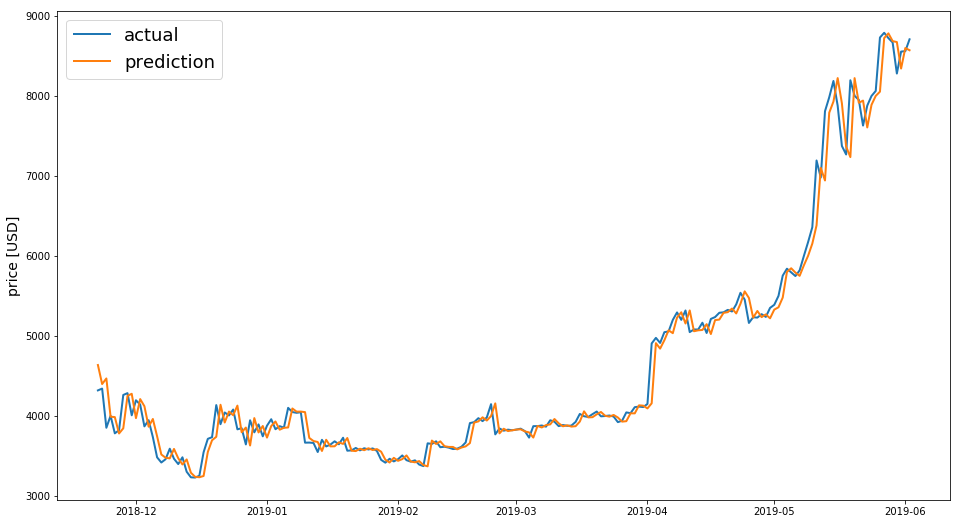

In [78]:
preds = test.close.values[:-7] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction')

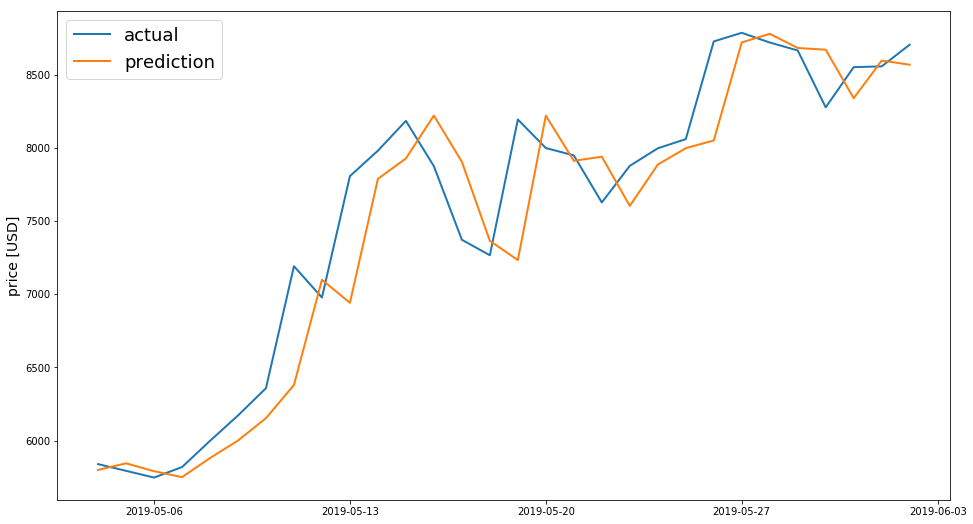

In [79]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction')